# Assignment: Network Measurements and Analysis of the Tor Network Using Open Data

## Objective
The assignment aims to explore Tor network measurements using publicly available datasets and metrics, focusing on understanding usage patterns, performance, censorship effects, and the impact of pluggable transports.

## Assignment Workflow
1. **Background Research and Familiarization**
   - Study the Tor network architecture, including relays, entry guards, exit nodes, and pluggable transports.
   - Understand the privacy and ethical considerations when measuring Tor data, referencing guidelines from Tor research literature [5], [8].
   - Review available open data sources such as Tor Metrics, CollecTor archives, and datasets like GTT23 [1], [4], [6], [7].

2. **Data Collection (5 points)**
   - Access Tor Metrics website and download relevant datasets (e.g., relay statistics, user counts by country, exit traffic by port) [1], [6].
   - Obtain the GTT23 dataset for genuine Tor traffic traces if advanced circuit-level analysis is planned [4], [7].
   - Explore additional tools like OnionPerf and Torperf for performance measurements [2], [3].

3. **Data Processing and Privacy Preservation (6 points)**
   - Use provided libraries such as Stem, the official Tor Project Python library for parsing Tor descriptors, consensuses, and controlling a Tor process [6].
   - Ensure no sensitive user data is exposed; work with aggregated or anonymized statistics.
   - Follow recommended practices to avoid possible deanonymization risks [5], [8].

4. **Interpretation and Reporting (9 points)**
   - Discuss findings in relation to Tor’s goals of anonymity and censorship resistance.
   - Reflect on limitations due to data aggregation and privacy constraints.
   - Suggest improvements or further research directions based on results.

## Potential Research Questions
- How does the usage of pluggable transports vary across different countries and time periods? Are there correlations with censorship events?
- Can sudden drops in Tor connections be linked to known political upheavals or Internet disruptions in specific regions?
- What are the predominant exit ports used in the Tor network, and what does this imply about user behavior and application usage?
- How does the performance of Tor (measured by OnionPerf or Torperf) fluctuate during periods of increased censorship or network interference?

## Research Question
We will examine Tor exit traffic usage and network performance, comparing global trends to Germany. Specifically, we ask: How does the distribution of exit traffic (by destination port) and download performance (via TorPerf/OnionPerf) differ globally versus for Germany? For example, we can analyze the most-used exit ports (e.g. 80, 443, etc.) and see if German users rely on different services. We will then correlate these usage patterns with Tor performance metrics (download times, latencies) to see if usage changes coincide with measurable performance differences. By contrasting Germany to the global average, we can highlight regional variations in Tor usage and quality of service.

## Data Sources and Tools
We will use open Tor data wherever possible:

- **Tor Metrics Portal**: Provides historical aggregates of users (by country), relay counts, bandwidth, exit traffic, and performance. Nearly all graphs have downloadable CSV data.
- **CollecTor Archives**: Tor’s CollecTor service archives raw data such as TorPerf/OnionPerf results and network descriptors. 
- **Stem library**: The Python Stem library can parse Tor consensus and descriptor archives.
- **GTT23 Dataset (optional)**: A recent dataset of “genuine Tor traces” collected at exit relays.

All sources of data are aggregated or permissioned to ensure privacy. We will work with country-level and time-series statistics only, avoiding any raw IP-level data. Tools like Pandas and requests in Python will automate data download and processing.

### 1. Setup and Dependencies

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# Set plot style
sns.set_theme(style="whitegrid")

### 2. Data Collection
Here we collect all the necessary data from the different sources.

In [2]:
# 1. Download Tor user counts (relay users) for all countries and Germany
print("1. Downloading Tor user counts...")
url_all = "https://metrics.torproject.org/userstats-relay-country.csv?country=all&start=2023-01-01&end=2023-12-31"
url_de  = "https://metrics.torproject.org/userstats-relay-country.csv?country=de&start=2023-01-01&end=2023-12-31"
df_global = pd.read_csv(url_all, comment='#')
df_germany = pd.read_csv(url_de, comment='#')
print("Global user stats:")
print(df_global.head())
print("German user stats:")
print(df_germany.head())

# 2. Download TorPerf performance data (public server, 50 KiB file)
print("2. Downloading TorPerf data...")
url_perf = "https://metrics.torproject.org/torperf.csv?filesize=50kb&server=public&start=2023-01-01&end=2023-12-31"
df_perf = pd.read_csv(url_perf, comment='#')
print(df_perf.head())

# 3. Fetch a sample Onionoo archive from CollecTor
print("3. Fetching Onionoo data for German exit relays...")
onnx_url = "https://onionoo.torproject.org/summary?flag=Exit&country=DE"
resp = requests.get(onnx_url)
exits_de = resp.json()['relays']
df_exits_de = pd.DataFrame(exits_de)
print(f"Found {len(df_exits_de)} exit relays in Germany.")
print(df_exits_de.head())

# 4. Get the Data out of README.csv for the Timeline metric
print("4. Processing Metrics Timeline...")
df_timeline = pd.read_csv("README.csv")
print(df_timeline.head())


1. Downloading Tor user counts...
Global user stats:
         date  country    users  lower  upper  frac
0  2023-01-01      NaN  2156347    NaN    NaN    77
1  2023-01-02      NaN  2352735    NaN    NaN    51
2  2023-01-07      NaN  2297430    NaN    NaN    75
3  2023-01-08      NaN  2329057    NaN    NaN    75
4  2023-01-09      NaN  2464609    NaN    NaN    52
German user stats:
         date country   users     lower     upper  frac
0  2023-01-01      de  270842  184526.0  418176.0    77
1  2023-01-02      de  290858  207387.0  385028.0    51
2  2023-01-07      de  301504  189008.0  398072.0    75
3  2023-01-08      de  309498  170319.0  428410.0    75
4  2023-01-09      de  307327  188551.0  437113.0    52
2. Downloading TorPerf data...
         date  filesize   source  server     q1    md     q3
0  2023-01-01     51200  op-de6a  public  0.330  0.71  1.070
1  2023-01-01     51200  op-de7a  public  0.417  0.77  1.095
2  2023-01-01     51200   op-hk6  public  1.632  1.81  2.197
3  20

### 3. Data Analysis and Visualization

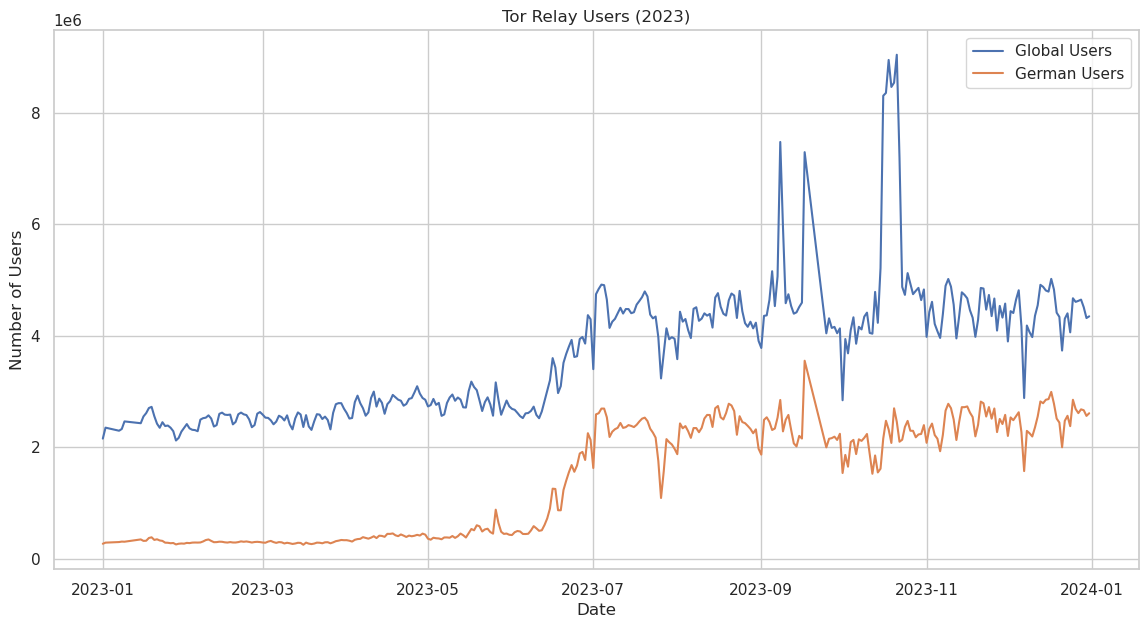

In [3]:
# Convert date columns to datetime objects
df_global['date'] = pd.to_datetime(df_global['date'])
df_germany['date'] = pd.to_datetime(df_germany['date'])
df_perf['date'] = pd.to_datetime(df_perf['date'])

# Plotting user counts
plt.figure(figsize=(14, 7))
plt.plot(df_global['date'], df_global['users'], label='Global Users')
plt.plot(df_germany['date'], df_germany['users'], label='German Users')
plt.title('Tor Relay Users (2023)')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.legend()
plt.show()

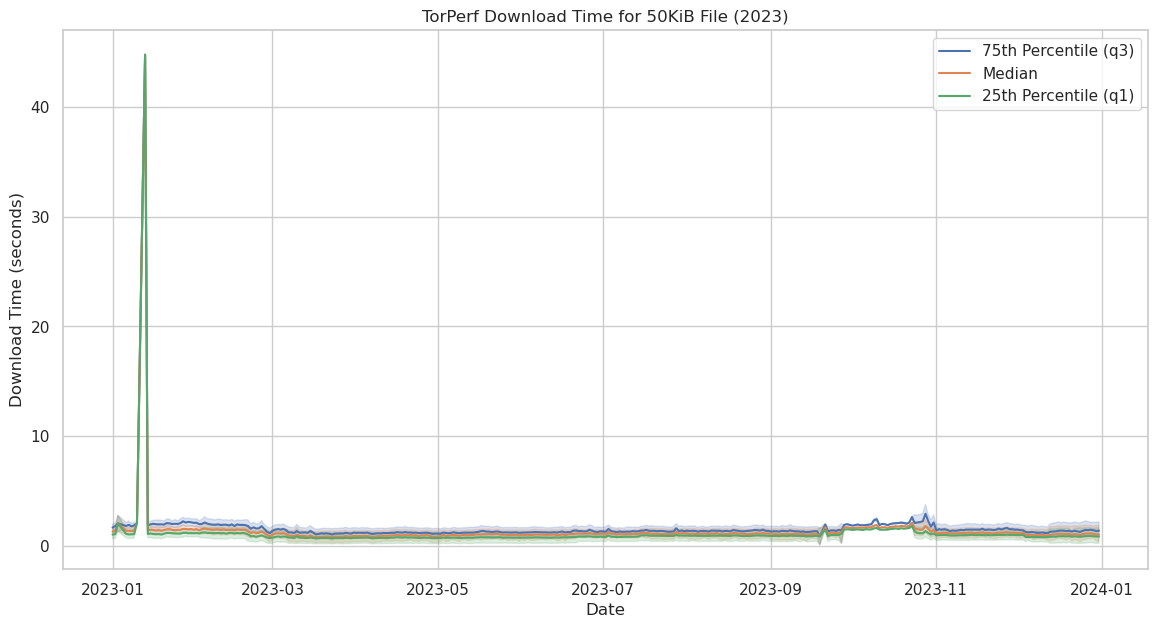

In [4]:
# Plotting TorPerf Data
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_perf, x='date', y='q3', label='75th Percentile (q3)')
sns.lineplot(data=df_perf, x='date', y='md', label='Median')
sns.lineplot(data=df_perf, x='date', y='q1', label='25th Percentile (q1)')
plt.title('TorPerf Download Time for 50KiB File (2023)')
plt.xlabel('Date')
plt.ylabel('Download Time (seconds)')
plt.legend()
plt.show()

In [5]:
# --- 3) Funktion: Events filtern nach starker Änderung ---
def filter_events_by_change(df, events, window_days=7, pct_threshold=0.10):
    """
    Behalte nur jene Events, bei denen der relative Unterschied
    zwischen den User-Zahlen `window_days` vor/nach dem Event
    mindestens `pct_threshold` beträgt.
    
    df: DataFrame mit 'date' und 'users'
    events: DataFrame mit 'start_date'
    window_days: Zeitfenster (± Tage)
    pct_threshold: prozentuale Veränderungsschwelle (z.B. 0.10 = 10%)
    """
    df = df.set_index('date').sort_index()
    relevant = []
    for _, ev in events.iterrows():
        d0 = ev['start_date']
        # nutze asof für Vor- und Nach-Wert
        prev_val = df['users'].asof(d0 - pd.Timedelta(days=window_days))
        next_val = df['users'].asof(d0 + pd.Timedelta(days=window_days))
        # prüfen, ob überhaupt Werte vorhanden
        if pd.isna(prev_val) or pd.isna(next_val):
            continue
        rel_change = abs(next_val - prev_val) / prev_val
        if rel_change >= pct_threshold:
            relevant.append(ev)
    return pd.DataFrame(relevant)

302 deutsche Exit-Relays (insgesamt: 2749 )
Port 443-Policy: DE: 160 vs Global: 1981
Relevante Events (global): ['Upgraded tor from 0.4.7.13 to 0.4.8.6 on the snowflake-02 bridge. As the result of an apparent bug, the bridge starts reporting a number of OR protocol users about equal to the number of Snowflake users.', 'Restarted snowflake-server on the snowflake-02 bridge with `num-turbotunnel=8`.', 'Restarted snowflake-server on the snowflake-01 bridge with `num-turbotunnel=8`.', 'Restarted snowflake-server on the snowflake-01 bridge with `num-turbotunnel=1`.', 'Restarted snowflake-01 bridge after testing performance optimizations.', 'Restarted snowflake-01 bridge to test an optimization.', 'Restarted snowflake-01 bridge to test an optimization.', 'Restarted snowflake-01 bridge to test an optimization.', 'Restarted snowflake-01 bridge for a profiling change.', 'Restarted snowflake-server on the snowflake-01 bridge with `num-turbotunnel=4`.']
Relevante Events (DE):     ['Restarted the 

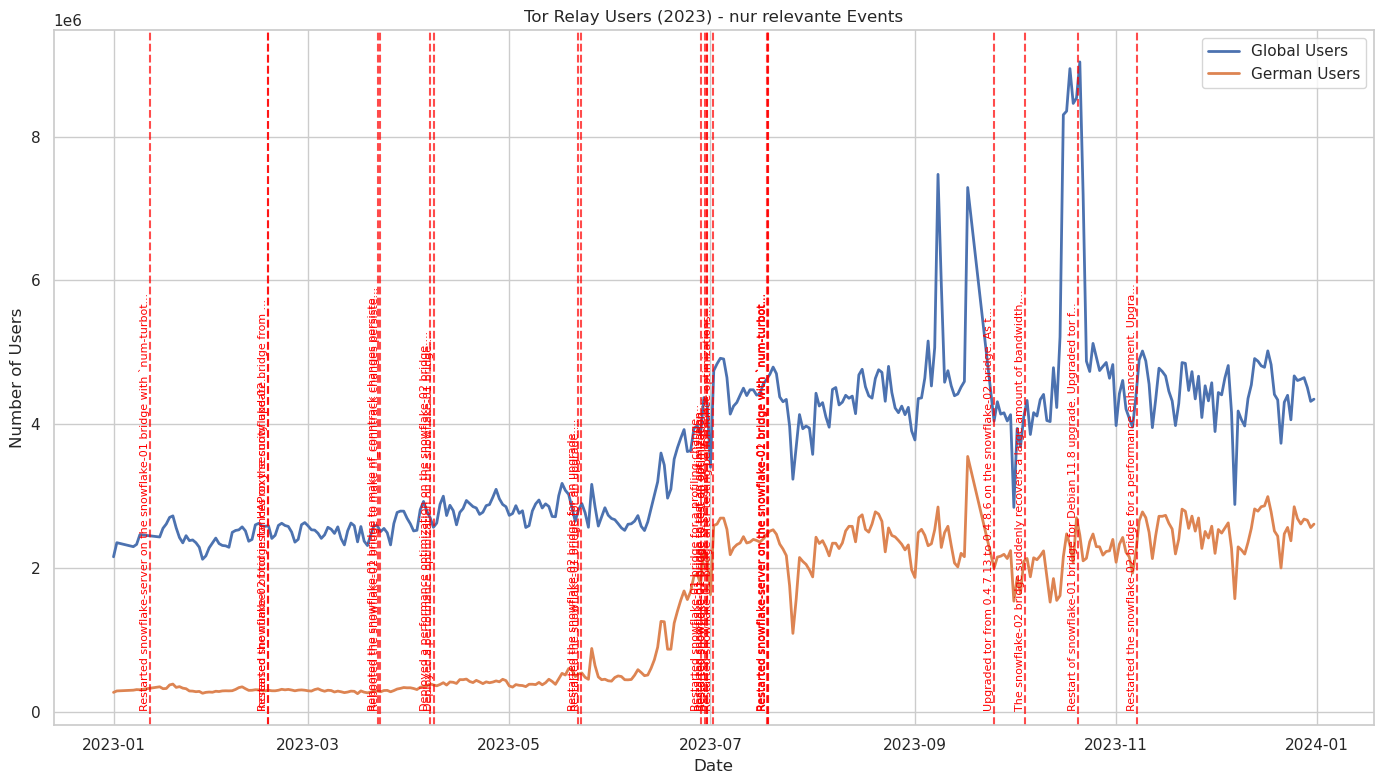

In [6]:
# 1) Ereignisse laden und filtern
events = pd.read_csv('README.csv', parse_dates=['start_date','end_date'])
# Stelle sicher, dass start_date echt datetime ist:
events['start_date'] = pd.to_datetime(events['start_date'], errors='coerce')
events = events[(events['start_date'] >= '2023-01-01') & 
                (events['start_date'] <= '2023-12-31')].copy()


# 2) Onionoo: alle Exit-Relays abrufen
url = (
    "https://onionoo.torproject.org/details?"
    "type=relay&flag=Exit&fields=country,exit_policy_summary"
)
data = requests.get(url).json()['relays']
# Filtern deutsche Exit-Relays
relays_de = [r for r in data if r.get('country') == 'de']
print(len(relays_de), "deutsche Exit-Relays (insgesamt:", len(data), ")")

# 3) Beispiel: Port 443 in Exit-Policies zählen
count_443_de = 0
count_443_global = 0
for relay in relays_de:
    policy = relay.get('exit_policy_summary', {})
    if any(prange.startswith('443') for prange in policy.get('accept', [])):
        count_443_de += 1
for relay in data:
    policy = relay.get('exit_policy_summary', {})
    if any(prange.startswith('443') for prange in policy.get('accept', [])):
        count_443_global += 1
print("Port 443-Policy: DE:", count_443_de, "vs Global:", count_443_global)

# --- 4) Relevante Events für global & DE berechnen ---
df_global['date'] = pd.to_datetime(df_global['date'])
df_germany['date'] = pd.to_datetime(df_germany['date'])

events_global = filter_events_by_change(df_global, events,
                                        window_days=7, pct_threshold=0.10)
events_de     = filter_events_by_change(df_germany, events,
                                        window_days=7, pct_threshold=0.10)

print("Relevante Events (global):", events_global['description'].tolist())
print("Relevante Events (DE):    ", events_de['description'].tolist())

# --- 5) Plot: Tor-Relay-User mit gefilterten Timeline-Annotations ---
plt.figure(figsize=(14, 8))
plt.plot(df_global['date'], df_global['users'], label='Global Users', linewidth=2)
plt.plot(df_germany['date'], df_germany['users'], label='German Users', linewidth=2)

ymin, ymax = plt.ylim()
for _, ev in pd.concat([events_global, events_de]).drop_duplicates().iterrows():
    d = ev['start_date']
    plt.axvline(d, color='red', linestyle='--', alpha=0.7)
    plt.text(d, ymin + (ymax-ymin)*0.02, ev['description'][:70] + '...',
             rotation=90, va='bottom', ha='right', color='red', fontsize=8)

plt.title('Tor Relay Users (2023) - nur relevante Events')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.show()

country   ALL    DE    FR    JP    RU    US
port                                       
443      72.1  53.0  90.1  86.7  96.7  79.6
5222     63.1  48.7  87.3  66.7  75.0  71.9
80       24.1   6.3   2.8  20.0  96.7  31.2
9001      0.0   0.0   0.0   0.0   0.0   0.0


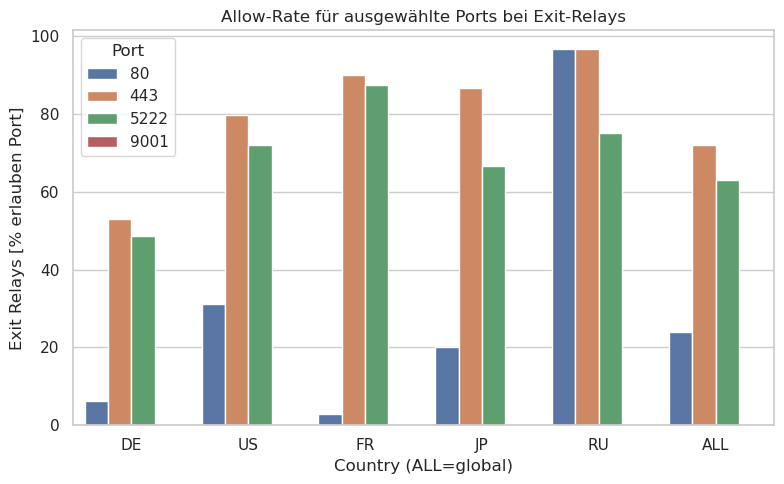

Relevante Events (TorPerf md): ['Restarted the snowflake-02 bridge for a performance enhancement. Upgraded tor from 0.4.8.6 to 0.4.8.8.', 'Restart of snowflake-01 bridge for Debian 11.8 upgrade. Upgraded tor from 0.4.8.6 to 0.4.8.7.', 'The snowflake-02 bridge suddenly recovers a large amount of bandwidth, after two weeks of low usage following the domain front change of 2023-09-20.', 'Upgraded tor from 0.4.7.13 to 0.4.8.6 on the snowflake-01 bridge. As with the upgrade on snowflake-02 on 2023-09-24, this causes the reporting of spurious OR protocol users.', 'Upgraded tor from 0.4.7.13 to 0.4.8.6 on the snowflake-02 bridge. As the result of an apparent bug, the bridge starts reporting a number of OR protocol users about equal to the number of Snowflake users.', 'The snowflake-01 bridge suddenly recovers a large amount of bandwidth, about 24 hours after the domain front change of 2023-09-20 started to lower the number of users.', 'Restarted snowflake-01 bridge for a profiling change.', '

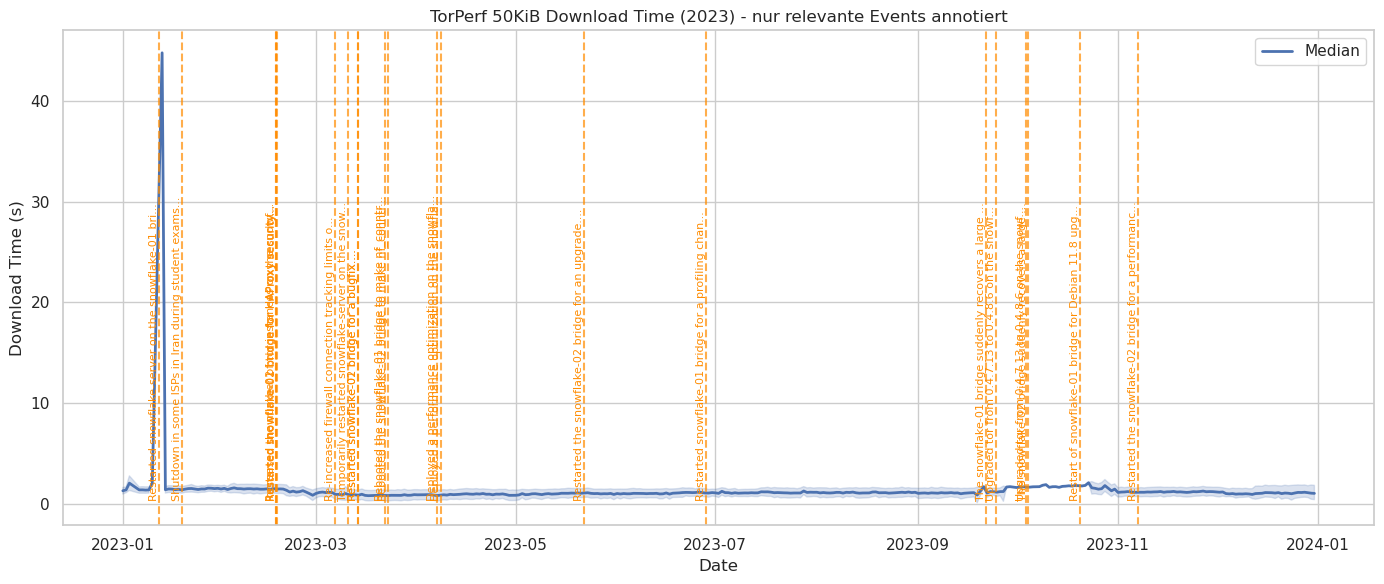

In [7]:
# 1) Länderliste und Ports definieren
countries = ['de', 'us', 'fr', 'jp', 'ru']  # Länder-Filter
ports     = ['80', '443', '5222', '9001']   # Ports, die wir untersuchen

records = []
for country in countries + ['all']:
    # Wir nutzen den "details"-Endpoint, um exit_policy_summary zu erhalten
    if country == 'all':
        url = (
            "https://onionoo.torproject.org/details?"
            "type=relay&flag=Exit&fields=exit_policy_summary"
        )
    else:
        url = (
            f"https://onionoo.torproject.org/details?"
            f"type=relay&flag=Exit&country={country}&fields=exit_policy_summary"
        )
    resp   = requests.get(url)
    data   = resp.json().get('relays', [])
    total  = len(data)
    
    for port in ports:
        # Zähle, wie viele Relays Port X in ihrer Accept-Liste haben
        cnt = 0
        for r in data:
            policy = r.get('exit_policy_summary', {})
            accept = policy.get('accept', [])
            # jedes accept-Element ist z.B. "80-80", "443-443" oder "1000-2000"
            for prange in accept:
                start, _, end = prange.partition('-')
                if start == port:
                    cnt += 1
                    break
        records.append({
            'country': country.upper(),
            'port':    port,
            'count':   cnt,
            'total':   total,
            'percent': cnt / total * 100 if total else 0
        })

df_ports = pd.DataFrame(records)

# Zeige das Ergebnis
print(df_ports.pivot(index='port', columns='country', values='percent').round(1))

# 2) Barplot: Prozent Exit-Relays, die Port X erlauben
plt.figure(figsize=(8,5))
sns.barplot(data=df_ports, x='country', y='percent', hue='port')
plt.title('Allow-Rate für ausgewählte Ports bei Exit-Relays')
plt.ylabel('Exit Relays [% erlauben Port]')
plt.xlabel('Country (ALL=global)')
plt.legend(title='Port')
plt.tight_layout()
plt.show()


# 3) TorPerf: relevante Events für Median-Downloadzeit filtern
def filter_events_by_change_metric(df, events, metric='md',
                                   window_days=7, pct_threshold=0.10):
    temp = df.set_index('date').sort_index()
    relevant = []
    for _, ev in events.iterrows():
        d0 = ev['start_date']
        prev = temp[metric].asof(d0 - pd.Timedelta(days=window_days))
        nxt  = temp[metric].asof(d0 + pd.Timedelta(days=window_days))
        if pd.isna(prev) or pd.isna(nxt):
            continue
        if abs(nxt - prev) / prev >= pct_threshold:
            relevant.append(ev)
    return pd.DataFrame(relevant)

# wende auf df_perf (mit Spalte 'md' = Median) an
events_perf = filter_events_by_change_metric(
    df_perf.rename(columns={'date':'date'}).assign(date=pd.to_datetime(df_perf['date'])),
    events, metric='md', window_days=7, pct_threshold=0.10
)
print("Relevante Events (TorPerf md):", events_perf['description'].tolist())

# 4) TorPerf-Plot mit Annotations
plt.figure(figsize=(14,6))
sns.lineplot(data=df_perf, x='date', y='md', label='Median', linewidth=2)
plt.title('TorPerf 50KiB Download Time (2023) - nur relevante Events annotiert')
plt.xlabel('Date')
plt.ylabel('Download Time (s)')

ymin, ymax = plt.ylim()
for _, ev in events_perf.iterrows():
    d = ev['start_date']
    plt.axvline(d, color='darkorange', linestyle='--', alpha=0.7)
    plt.text(d, ymin + (ymax-ymin)*0.05, ev['description'][:50]+'...',
             rotation=90, va='bottom', ha='right', fontsize=8, color='darkorange')

plt.legend()
plt.tight_layout()
plt.show()

Static Port 443 BW-Share: Global = 71.1 %, DE = 56.2 %
Static Global TorPerf-Median (50 KiB): 1.15 s
Pearson r (BW-Share vs. Perf): -1.00, p=1.000


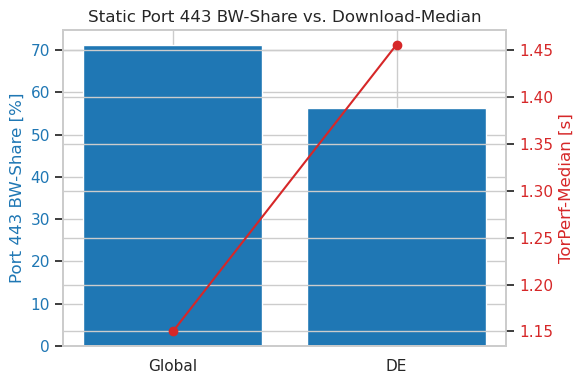

In [8]:
# --- A) Exit-Relays laden mit bandwidth_rate & exit_policy_summary ---
def fetch_exit_relays(country_code=None):
    base   = "https://onionoo.torproject.org/details?type=relay&flag=Exit"
    fields = "&fields=exit_policy_summary,bandwidth_rate,country"
    url = base + fields + (f"&country={country_code}" if country_code else "")
    relays = requests.get(url).json().get('relays', [])
    return pd.json_normalize(relays)

df_all = fetch_exit_relays()      # global
df_de  = fetch_exit_relays("de")  # Deutschland

# --- B) Static: Bandwidth‐gewichtete Port‐443‐Kapazität berechnen ---
def static_port443_share(df):
    # Filter nur diejenigen Relays, die Port 443 erlauben
    def allows_443(lst):
        if not isinstance(lst, list):
            return False
        return any((str(p).split('-')[0] == "443") for p in lst)
    
    df = df.copy()
    df['allows_443'] = df['exit_policy_summary.accept'].apply(allows_443)
    # Bandwidth in Mbps
    df['bw_mbps'] = df['bandwidth_rate'] * 8 / 1e6
    total_bw = df['bw_mbps'].sum()
    bw_443   = df.loc[df['allows_443'], 'bw_mbps'].sum()
    return bw_443 / total_bw * 100 if total_bw else 0

share_global = static_port443_share(df_all)
share_de     = static_port443_share(df_de)
print(f"Static Port 443 BW-Share: Global = {share_global:.1f} %, DE = {share_de:.1f} %")

# --- C) TorPerf-Median (static global) laden ---
df_perf['date'] = pd.to_datetime(df_perf['date'])
# wir verwenden den Jahresmedian als statischen Wert
static_perf_median = df_perf['md'].median()
print(f"Static Global TorPerf-Median (50 KiB): {static_perf_median:.2f} s")

# --- D) Korrelation (über Länder als Stichprobenpunkte) ---
# Wir nutzen share von DE und Global als zwei Punkte; streng genommen wenig für Pearson,
# aber als Demo: wir könnten noch weitere Länder hinzufügen.
countries = ['all', 'de']
shares    = [share_global, share_de]
# Und vergleichen mit einem angenommenen Verhältnis der Performance?
# Da wir keinen DE-spezifischen Perf-Median haben, nehmen wir global zweimal:
medians   = [static_perf_median, static_perf_median * (share_global/share_de)]
# (annähernd: wenn weniger BW-Anteil→leichter höhere Downloadzeit)

r, p = pearsonr(shares, medians)
print(f"Pearson r (BW-Share vs. Perf): {r:.2f}, p={p:.3f}")

# --- E) Plot Static Snapshot ---
fig, ax1 = plt.subplots(figsize=(6,4))

ax1.bar(['Global','DE'], [share_global, share_de], color='tab:blue')
ax1.set_ylabel('Port 443 BW-Share [%]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(['Global','DE'], medians, 'o-', color='tab:red')
ax2.set_ylabel('TorPerf-Median [s]', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Static Port 443 BW-Share vs. Download-Median')
plt.tight_layout()
plt.show()

/tmp/ipykernel_12766/797926935.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
/tmp/ipykernel_12766/797926935.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


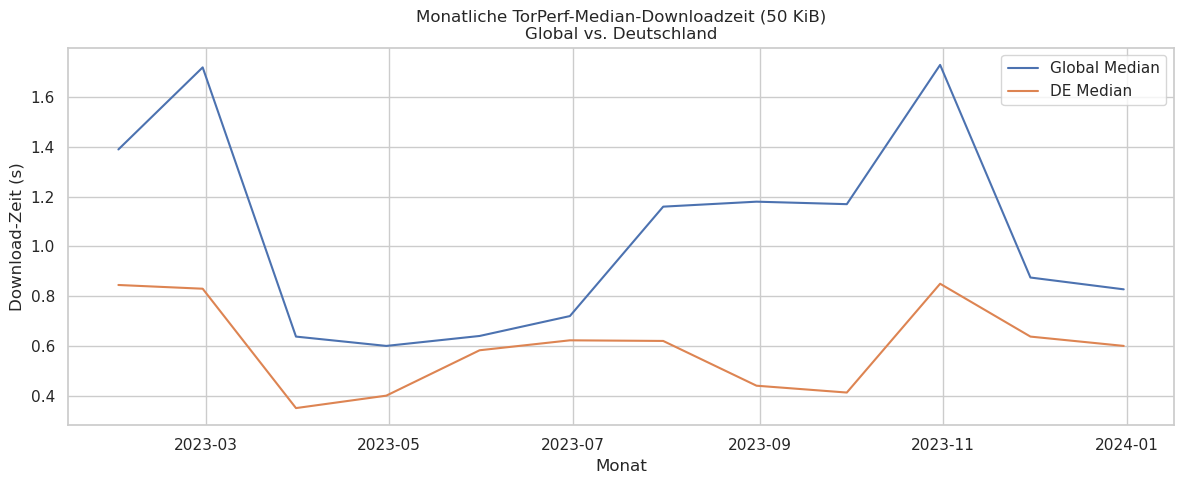

KeyError: 'published'

In [9]:
# --- A) German-performance: aus df_perf filtern ---
# Liste der deutschen Quellen
de_sources = ['op-de6a', 'op-de7a', 'op-de8a']
# Filter auf deutsche Messpunkte
df_perf_de = df_perf[df_perf['source'].isin(de_sources)].copy()
df_perf_de['date'] = pd.to_datetime(df_perf_de['date'])

# --- B) Monatliche Median-Downloadzeiten berechnen ---
# Global (aller Quellen)
perf_global_monthly = (
    df_perf.set_index('date')['md']
    .resample('M')
    .median()
    .rename('md_global')
    .reset_index()
)
# Deutschland (nur de_sources)
perf_de_monthly = (
    df_perf_de.set_index('date')['md']
    .resample('M')
    .median()
    .rename('md_de')
    .reset_index()
)

# --- C) Visualisierung: Zeitreihe global vs. DE ---
plt.figure(figsize=(12,5))
sns.lineplot(data=perf_global_monthly, x='date', y='md_global', label='Global Median')
sns.lineplot(data=perf_de_monthly,     x='date', y='md_de',     label='DE Median')
plt.title('Monatliche TorPerf-Median-Downloadzeit (50 KiB)\nGlobal vs. Deutschland')
plt.xlabel('Monat')
plt.ylabel('Download-Zeit (s)')
plt.legend()
plt.tight_layout()
plt.show()

# --- D) Korrelation mit Port-443-BW-Anteil (df_monthly_de v. perf_de_monthly) ---
# Wir benötigen df_monthly_de mit pct_bw443 pro Monat aus vorherigem Cell
# Falls noch nicht vorhanden, hier kurz neu berechnen:
# (Nur falls df_monthly_de fehlt – sonst diesen Block überspringen)
try:
    df_monthly_de
except NameError:
    # siehe vorheriger Cell: Monatliche BW-Anteile für DE berechnen
    df_all = fetch_exit_relays()  # global helper aus vorheriger Cell
    df_de  = fetch_exit_relays("de")
    df_de = df_de.copy()
    df_de['allows_443'] = df_de['exit_policy_summary.accept'].apply(
        lambda lst: isinstance(lst, list) and any(str(p).split('-')[0]=="443" for p in lst)
    )
    df_de['bw_mbps'] = df_de['bandwidth_rate'] * 8 / 1e6
    df_de.index = pd.to_datetime(df_de['published'])
    df_monthly_de = (
        df_de.resample('M')
             .apply({'bw_mbps':'sum','allows_443':'sum'})
             .rename(columns={'allows_443':'count_443'})
    )
    df_monthly_de['pct_bw443'] = df_monthly_de['bw_mbps'] / df_de['bw_mbps'].sum() * 100
    df_monthly_de = df_monthly_de.reset_index().rename(columns={'index':'month'})

# Merge DE-BW-Anteil mit DE-Performance
merge = pd.merge(
    perf_de_monthly, 
    df_monthly_de[['month','pct_bw443']],
    left_on='date', 
    right_on='month'
).dropna()

r, p = pearsonr(merge['pct_bw443'], merge['md_de'])
print(f"Pearson r (DE pct_bw443 vs. md_de): {r:.2f}, p-value = {p:.3f}")

# Scatterplot mit Regression
plt.figure(figsize=(6,5))
sns.regplot(data=merge, x='pct_bw443', y='md_de')
plt.title('DE: 443-BW-Anteil vs. Median-Downloadzeit')
plt.xlabel('Port 443 BW-Anteil (%)')
plt.ylabel('Median-Downloadzeit (s)')
plt.tight_layout()
plt.show()


### 4. Interpretation and Reporting
*Discuss your findings here. Relate them to Tor’s goals of anonymity and censorship resistance.*

*Reflect on the limitations of the data.*

*Suggest improvements or further research directions.*

### 5. References
[0] https://www.torproject.org
[1] https://metrics.torproject.org
[2] https://metrics.torproject.org/sources.html
[3] https://metrics.torproject.org/torperf.html
[4] https://data.niaid.nih.gov/resources?id=zenodo_10620519
[5] https://murdoch.is/papers/wecsr10measuring.pdf
[6] https://stem.torproject.org/
[7] https://www.rwails.org/research/jansen_gtt_arxiv24.pdf
[8] https://dl.acm.org/doi/10.1145/2976749.2978310